/home/orion/.local/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}



ERROR:   Could not load MultiNest library "libmultinest.so"
ERROR:   You have to build it first,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: http://johannesbuchner.github.com/PyMultiNest/install.html


ERROR:   Could not load MultiNest library: libmultinest.so
ERROR:   You have to build MultiNest,
ERROR:   and point the LD_LIBRARY_PATH environment variable to it!
ERROR:   manual: http://johannesbuchner.github.com/PyMultiNest/install.html

problem: libmultinest.so: cannot open shared object file: No such file or directory


Text(0, 0.5, 'Relative flux')

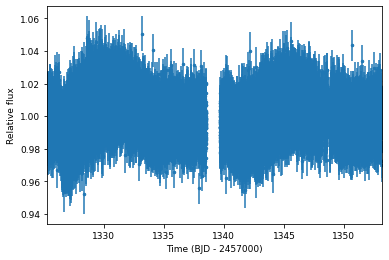

In [1]:
import juliet
import numpy as np
import matplotlib.pyplot as plt

# First,get arrays of times, normalized-fluxes and errors for HATS-46 from Sector 1 from MAST:
t, f, ferr  = juliet.get_TESS_data('https://archive.stsci.edu/hlsps/'+\
                                   'tess-data-alerts/hlsp_tess-data-'+\
                                   'alerts_tess_phot_00281541555-s01_'+\
                                   'tess_v1_lc.fits')
# Plot the data:
plt.errorbar(t,f,yerr=ferr,fmt='.')
plt.xlim([np.min(t),np.max(t)])
plt.xlabel('Time (BJD - 2457000)')
plt.ylabel('Relative flux')

In [2]:
# Period and t0 from Anderson et al. (201X):
P,t0 =  4.7423729 ,  2457376.68539 - 2457000
# Get phases --- identify out-of-transit (oot) times by phasing the data
# and selecting all points at absolute phases larger than 0.02:
phases = juliet.utils.get_phases(t, P, t0)
idx_oot = np.where(np.abs(phases)>0.02)[0]
# Save the out-of-transit data into dictionaries so we can feed them to juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot],f[idx_oot],ferr[idx_oot]

In [3]:
# Set the priors:
params =  ['mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', 'GP_sigma_TESS', \
           'GP_rho_TESS']
dists =   ['fixed',          'normal',     'loguniform',   'loguniform',\
           'loguniform']
hyperps = [1., [0.,0.1], [1e-6, 1e6], [1e-6, 1e6],\
           [1e-3,1e3]]

priors = {}
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

# Perform the juliet fit. Load dataset first (note the GP regressor will be the times):
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, GP_regressors_lc = times, \
                      out_folder = 'hats46_detrending')
# Fit:
results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.


6546it [04:58, 21.90it/s, +500 | bound: 64 | nc: 1 | ncall: 135898 | eff(%):  5.185 | loglstar:   -inf < 55441.914 <    inf | logz: 55429.592 +/-  0.143 | dlogz:  0.001 >  0.509]


(1325.2988290684266, 1353.179868077501)

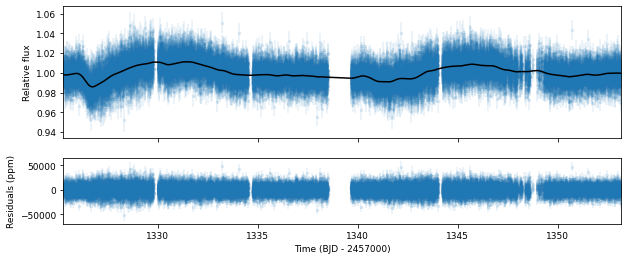

In [4]:
# Import gridspec:
import matplotlib.gridspec as gridspec
# Get juliet model prediction for the full lightcurve:
model_fit = results.lc.evaluate('TESS')

# Plot:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])

# First the data and the model on top:
ax1 = plt.subplot(gs[0])
ax1.errorbar(times['TESS'], fluxes['TESS'], fluxes_error['TESS'],fmt='.',alpha=0.1)
ax1.plot(times['TESS'], model_fit, color='black', zorder=100)
ax1.set_ylabel('Relative flux')
ax1.set_xlim(np.min(times['TESS']),np.max(times['TESS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Now the residuals:
ax2 = plt.subplot(gs[1])
ax2.errorbar(times['TESS'], (fluxes['TESS']-model_fit)*1e6, \
             fluxes_error['TESS']*1e6,fmt='.',alpha=0.1)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD - 2457000)')
ax2.set_xlim(np.min(times['TESS']),np.max(times['TESS']))

PyMultinest installation not detected. Forcing dynesty as the sampler.


11919it [09:43, 20.42it/s, +500 | bound: 170 | nc: 1 | ncall: 272800 | eff(%):  4.552 | loglstar:   -inf < 57000.437 <    inf | logz: 56977.238 +/-  0.310 | dlogz:  0.001 >  0.509]


Text(0.5, 0, 'Phases')

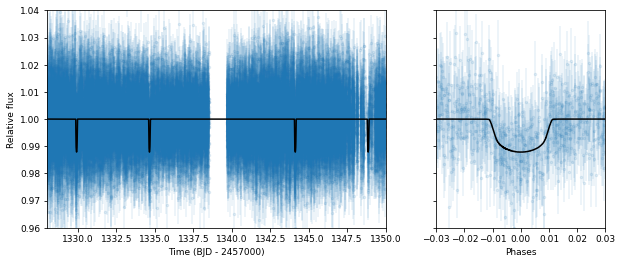

In [5]:
# Get model prediction from juliet:
model_prediction = results.lc.evaluate('TESS', t = t, GPregressors = t)

# Repopulate dictionaries with new detrended flux:
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, f/model_prediction, \
                                                      ferr/model_prediction

# Set transit fit priors:
priors = {}

params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
              'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS']

dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
                 'loguniform', 'fixed', 'normal', 'loguniform']

hyperps = [[4.7,0.1], [1329.9,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
                   [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

# Perform juliet fit:
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                  yerr_lc = fluxes_error, out_folder = 'hats46_detrended_transitfit')

results = dataset.fit()

# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_xlim([1328,1350])
ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black',zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlim([-0.03,0.03])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')

In [6]:
# First define the priors:
priors = {}

# Same priors as for the transit-only fit, but we now add the GP priors:
params = ['P_p1','t0_p1','r1_p1','r2_p1','q1_TESS','q2_TESS','ecc_p1','omega_p1',\
          'rho', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', \
          'GP_sigma_TESS', 'GP_rho_TESS']

dists = ['normal','normal','uniform','uniform','uniform','uniform','fixed','fixed',\
         'loguniform', 'fixed', 'normal', 'loguniform', \
         'loguniform', 'loguniform']

hyperps = [[4.7,0.1], [1329.9,0.1], [0.,1], [0.,1.], [0., 1.], [0., 1.], 0.0, 90.,\
           [100., 10000.], 1.0, [0.,0.1], [0.1, 1000.], \
           [1e-6, 1e6], [1e-3, 1e3]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr
dataset = juliet.load(priors=priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, GP_regressors_lc = times, out_folder = 'hats46_transitGP', verbose = True)

results = dataset.fit()

	 Transit fit detected for instrument  TESS
	 >> ecc,omega parametrization detected for lc planet p1
	 >> (b,p) parametrization detected for lc planet p1
PyMultinest installation not detected. Forcing dynesty as the sampler.


13527it [19:07, 11.78it/s, +500 | bound: 189 | nc: 1 | ncall: 312113 | eff(%):  4.494 | loglstar:   -inf < 56871.397 <    inf | logz: 56844.954 +/-  0.284 | dlogz:  0.001 >  0.509]


(0.96, 1.04)

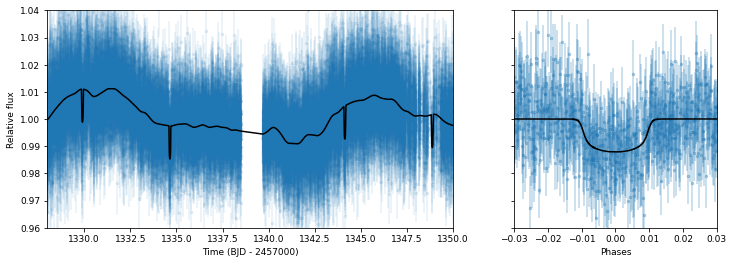

In [7]:
# Extract full model:
transit_plus_GP_model = results.lc.evaluate('TESS')

# Deterministic part of the model (in our case transit divided by mflux):
transit_model = results.lc.model['TESS']['deterministic']

# GP part of the model:
gp_model = results.lc.model['TESS']['GP']

# Now plot. First preambles:
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot data
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# Plot the (full, transit + GP) model:
ax1.plot(dataset.times_lc['TESS'], transit_plus_GP_model, color='black',zorder=10)

ax1.set_xlim([1328,1350])
ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

ax2 = plt.subplot(gs[1])

# Now plot phase-folded lightcurve but with the GP part removed:
ax2.errorbar(phases, dataset.data_lc['TESS'] - gp_model, \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.3)

# Plot transit-only (divided by mflux) model:
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black',zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
ax2.set_xlabel('Phases')
ax2.set_xlim([-0.03,0.03])
ax2.set_ylim([0.96,1.04])
